# 미세먼지 유발 영향인자 분석 및 예측


미세먼지로인해 사회경제적 비용이 증가하고있다.   
미세먼지를 유발하는 영향 인자를 분석하고, 미세먼지 발생 정도를 예측하여 미세먼지로 인한 사회적 비용을 최소화하고자 한다.

> **가설**
- 가설1: 대기오염물질 농도가 모델 구축에 유의미한 변수일 것
- 가설2: 대기환경적 요인이 미세먼지와 관련있는 예측 변수일 것
   
<br>   

# Data info
- 2019년 7월 ~ 2020년 6월 서울시 중구 대기환경 데이터
- features
  - PM10(미세먼지 농도), O3(오존 농도), NO2(이산화질소 농도), CO(일산화탄소 농도), SO2(이산화황 농도) 
  - 강수량, 풍량, 풍향, 습도, 기압, 적설, 전운량



#환경 세팅 및 데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# from sklearn.feature_selection import RFE
# from sklearn.preprocessing import StandardScaler
# from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
# from sklearn.ensemble import RandomForestRegressor as RFR
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz
import os
# os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/"

In [ ]:
!apt install fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

In [ ]:
# matplotlib.rc("font", family = "NanumBarunGothic")
# matplotlib.rc("axes", unicode_minus = False)

In [ ]:
df = pd.read_csv("AIR_POLLUTION.csv")
df.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


# 데이터 전처리

## 원본 데이터 확인

> **독립변수** : PM10 (미세먼지 농도)  
> **종속변수** : PM10 이외의 나머지 변수들  

- PM10, O3, NO2, CO, SO2는 모두 대기오염물질에 해당한다.

- PM10은 입자 크기가 10㎛ 이하인 먼지를 말하며, 초미세먼지(PM2.5)와 구분된다.

In [ ]:
df.shape

(366, 14)

In [ ]:
df.head()

,MeasDate,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,0.003,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,0.003,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,0.003,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,0.003,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,0.003,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


데이터 요약정보를 확인한다.

In [ ]:
df.describe().round(2)

,PM10,O3,NO2,CO,SO2,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
count,365.00,365.00,365.00,311.00,365.0,366.00,366.00,366.00,366.00,366.00,366.00,366.00,366.00
mean,33.42,0.02,0.03,0.52,0.0,13.86,0.38,2.23,209.45,60.30,1005.85,0.02,5.06
std,15.94,0.01,0.01,0.15,0.0,9.83,1.12,0.72,70.74,14.53,8.13,0.22,2.99
min,5.00,0.00,0.01,0.30,0.0,-7.95,0.00,0.94,50.00,17.90,983.80,0.00,0.00
25%,22.00,0.01,0.02,0.40,0.0,5.49,0.00,1.72,160.25,49.65,999.40,0.00,2.51
50%,31.00,0.02,0.02,0.50,0.0,14.00,0.00,2.09,221.00,61.05,1006.45,0.00,5.31
75%,42.00,0.03,0.03,0.60,0.0,23.07,0.12,2.62,266.00,69.95,1011.58,0.00,7.57
max,101.00,0.06,0.06,1.00,0.0,31.72,11.80,5.88,351.00,95.00,1025.50,3.20,10.00


### 문제점 1 : SO2 데이터
- min=0, max=0으로 전부 0이라는 값을 가진 것을 확인할 수 있다.  
- SO2는 아황산가스로 대기오염물질에 속하지만, 측정값이 없기 때문에 분석에서 사용할 수 없다고 판단하였다.  

In [ ]:
df.drop(["SO2"], axis = 1, inplace = True)
df.head()

,MeasDate,PM10,O3,NO2,CO,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD
0,2019-07-01,29.0,0.054,0.021,0.5,24.03,0.0,2.30,249,63.2,995.1,0.0,5.70
1,2019-07-02,26.0,0.053,0.020,0.5,24.29,0.0,2.26,265,63.2,998.6,0.0,3.83
2,2019-07-03,30.0,0.042,0.023,0.4,24.18,0.0,1.79,280,65.3,998.3,0.0,6.29
3,2019-07-04,28.0,0.034,0.026,0.4,25.35,0.0,2.04,263,58.6,996.6,0.0,2.54
4,2019-07-05,29.0,0.045,0.035,0.5,27.30,0.0,1.45,175,45.5,993.5,0.0,3.92


> 해당 column을 drop하여 제거한 것을 확인할 수 있다.

### 문제점 2 : RAIN 데이터
- RAIN(강수량) 데이터의 신뢰성에 의문을 가지게 되었다.  
1년간의 데이터인데 **최대 강수량이 11.8mm**라는 것은 원본 데이터에 문제가 있는 것이라고 판단했다.
- 정확한 데이터를 찾아 원본표를 수정할 필요성이 있다.

<br>

기상자료개방포털 : https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do#
- 서울시 2019년 ~ 2020년 일별 강수량 데이터
- 비가 오지 않은 날은 NaN으로 표기되어있어, 0으로 바꿀 필요 있음

In [ ]:
rain_df = pd.read_csv("SEOUL_RAIN.csv", encoding = "euc-kr")
rain_df.head()

,지점번호,지점명,일시,강수량(mm),1시간최다강수량(mm),1시간최다강수량시각
0,\t108,서울,2019-01-01,NaN,NaN,NaN
1,\t108,서울,2019-01-02,NaN,NaN,NaN
2,\t108,서울,2019-01-03,NaN,NaN,NaN
3,\t108,서울,2019-01-04,NaN,NaN,NaN
4,\t108,서울,2019-01-05,NaN,NaN,NaN


In [ ]:
rain_df.drop(["지점번호", "지점명", "1시간최다강수량(mm)", "1시간최다강수량시각"], axis =1 , inplace = True)
rain_df.head()

,일시,강수량(mm)
0,2019-01-01,NaN
1,2019-01-02,NaN
2,2019-01-03,NaN
3,2019-01-04,NaN
4,2019-01-05,NaN


In [ ]:
rain_df = rain_df.fillna(0)
rain_df

,일시,강수량(mm)
0,2019-01-01,0.0
1,2019-01-02,0.0
2,2019-01-03,0.0
3,2019-01-04,0.0
4,2019-01-05,0.0
...,...,...
732,0,0.0
733,0,0.0
734,0,0.0
735,0,0.0


In [ ]:
# 원본 데이터와 새로운 강수량 데이터 merge
df_merge = pd.merge(df, rain_df, how = 'left', left_on = 'MeasDate', right_on= '일시' )
df_merge

,MeasDate,PM10,O3,NO2,CO,TEMP,RAIN,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,일시,강수량(mm)
0,2019-07-01,29.0,0.054,0.021,0.5,24.03,0.00,2.30,249,63.2,995.1,0.0,5.70,2019-07-01,0.0
1,2019-07-02,26.0,0.053,0.020,0.5,24.29,0.00,2.26,265,63.2,998.6,0.0,3.83,2019-07-02,0.0
2,2019-07-03,30.0,0.042,0.023,0.4,24.18,0.00,1.79,280,65.3,998.3,0.0,6.29,2019-07-03,0.0
3,2019-07-04,28.0,0.034,0.026,0.4,25.35,0.00,2.04,263,58.6,996.6,0.0,2.54,2019-07-04,0.0
4,2019-07-05,29.0,0.045,0.035,0.5,27.30,0.00,1.45,175,45.5,993.5,0.0,3.92,2019-07-05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-06-26,19.0,0.039,0.016,0.4,21.66,0.41,3.12,228,84.0,996.0,0.0,8.73,2020-06-26,2.1
362,2020-06-27,22.0,0.044,0.017,0.4,23.94,0.00,1.93,217,69.8,995.8,0.0,6.21,2020-06-27,0.0
363,2020-06-28,27.0,0.044,0.009,0.4,25.03,0.00,2.35,283,71.3,994.7,0.0,2.63,2020-06-28,0.0
364,2020-06-29,36.0,0.026,0.028,0.6,24.06,1.26,2.48,103,75.5,992.9,0.0,7.58,2020-06-29,11.9


두 데이터를 합쳐 `df_merge`라는 새로운 데이터프레임을 생성하였다.   
날짜 데이터는 설명변수에 포함되지 않으므로 |제거한다.

In [ ]:
# 날짜 데이터 제거
df_merge.drop(['일시'], axis =1 , inplace = True)
df_merge.drop(['MeasDate'], axis=1, inplace = True)

# 기존의 잘못된 RAIN 제거
df_merge.drop(['RAIN'], axis=1, inplace = True) 

In [ ]:
# 새로운 강수량 데이터를 rename
df_merge.rename(columns = {'강수량(mm)':'RAIN'},inplace=True)
df_merge.describe().round(2)

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,RAIN
count,365.00,365.00,365.00,311.00,366.00,366.00,366.00,366.00,366.00,366.00,366.00,366.00
mean,33.42,0.02,0.03,0.52,13.86,2.23,209.45,60.30,1005.85,0.02,5.06,2.95
std,15.94,0.01,0.01,0.15,9.83,0.72,70.74,14.53,8.13,0.22,2.99,9.25
min,5.00,0.00,0.01,0.30,-7.95,0.94,50.00,17.90,983.80,0.00,0.00,0.00
25%,22.00,0.01,0.02,0.40,5.49,1.72,160.25,49.65,999.40,0.00,2.51,0.00
50%,31.00,0.02,0.02,0.50,14.00,2.09,221.00,61.05,1006.45,0.00,5.31,0.00
75%,42.00,0.03,0.03,0.60,23.07,2.62,266.00,69.95,1011.58,0.00,7.57,0.50
max,101.00,0.06,0.06,1.00,31.72,5.88,351.00,95.00,1025.50,3.20,10.00,64.70


### 문제점 3: SNOW 데이터
- 너무 작은 평균과 표준편차때문에, 데이터 확인 필요
- 0이 아닌 값을 확인해 보았음
- 적설량 0이 아닌 데이터가 6개로 유의미한 분석을 할 수 없다고 판단, 제거함

In [ ]:
con = (df['SNOW'] != 0)
df_merge[con]

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,SNOW,CLOUD,RAIN
202,62.0,0.015,0.036,0.8,1.82,2.10,205,63.5,1008.1,0.3,5.33,0.6
218,23.0,0.019,0.024,0.5,-1.42,2.86,226,52.3,1015.8,0.6,4.08,1.7
219,22.0,0.023,0.010,0.3,-7.95,3.34,323,38.4,1020.4,0.5,0.00,0.0
230,25.0,0.025,0.012,0.5,-0.57,3.94,270,82.7,1002.4,2.1,9.21,13.4
231,38.0,0.027,0.011,0.4,-5.64,3.43,303,66.5,1006.7,3.2,7.58,1.0
232,22.0,0.021,0.020,0.4,-4.28,2.33,284,44.3,1016.0,1.7,0.00,0.0


In [ ]:
df_merge.drop(["SNOW"], axis = 1, inplace = True)

### 데이터 시각화
- 모두 연속형 변수이므로, hitogram을 통해 시각적인 분포를 확인하였다.
- 표현하고자하는 변수가 대기오염물질인경우 **황색 그래프로 표시**하였다.

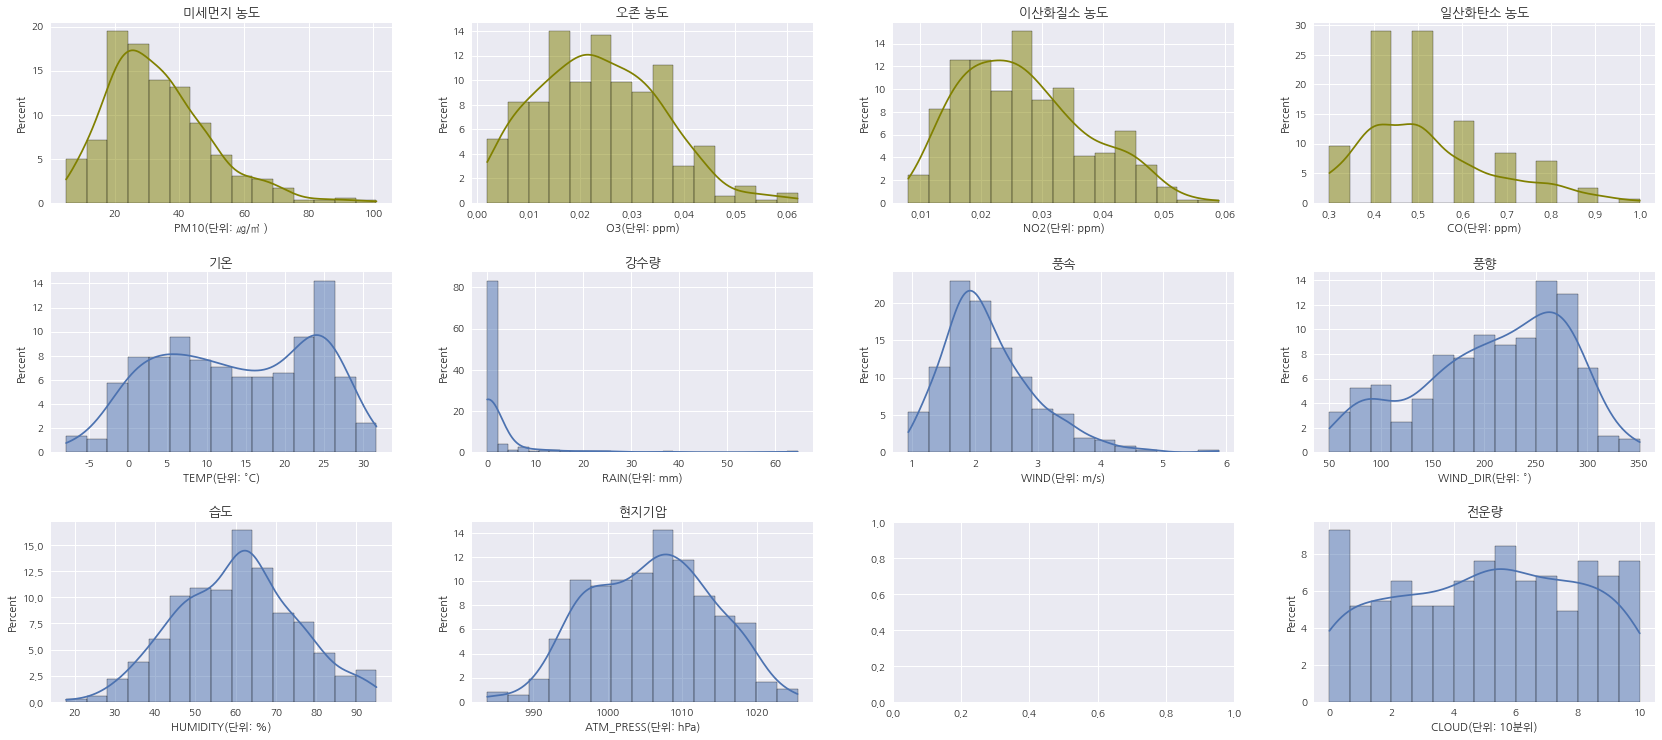

In [ ]:
matplotlib.rc("font", family = "NanumGothic") # 한글 깨짐 방지

fig, axes = plt.subplots(3,4,figsize=(20, 15))
plt.tight_layout(w_pad = 5, h_pad = 5)
plt.style.use('seaborn')

ax = sns.histplot(df_merge["PM10"],
                  color = 'olive',
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[0,0])
ax.set_title("미세먼지 농도", fontsize = 13)
ax.set_xlabel("PM10(단위: ㎍/㎥ )")

ax = sns.histplot(df_merge["O3"],
                  color = 'olive',
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[0,1])
ax.set_title("오존 농도", fontsize = 13)
ax.set_xlabel("O3(단위: ppm)")

ax = sns.histplot(df_merge["NO2"],
                  color = 'olive',
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[0,2])
ax.set_title("이산화질소 농도", fontsize = 13)
ax.set_xlabel("NO2(단위: ppm)")

ax = sns.histplot(df_merge["CO"],
                  color = 'olive',
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[0,3])
ax.set_title("일산화탄소 농도", fontsize = 13)
ax.set_xlabel("CO(단위: ppm)")

ax = sns.histplot(df_merge["TEMP"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[1, 0])
ax.set_title("기온", fontsize = 13)
ax.set_xlabel("TEMP(단위: °C)")

ax = sns.histplot(df_merge["RAIN"],
                  bins = 30,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[1,1])
ax.set_title("강수량", fontsize = 13)
ax.set_xlabel("RAIN(단위: mm)")

ax = sns.histplot(df_merge["WIND"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[1,2])
ax.set_title("풍속", fontsize = 13)
ax.set_xlabel("WIND(단위: m/s)")

ax = sns.histplot(df_merge["WIND_DIR"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[1,3])
ax.set_title("풍향", fontsize = 13)
ax.set_xlabel("WIND_DIR(단위: °)")

ax = sns.histplot(df_merge["HUMIDITY"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[2,0])
ax.set_title("습도", fontsize = 13)
ax.set_xlabel("HUMIDITY(단위: %)")

ax = sns.histplot(df_merge["ATM_PRESS"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[2,1])
ax.set_title("현지기압", fontsize = 13)
ax.set_xlabel("ATM_PRESS(단위: hPa)")

ax = sns.histplot(df_merge["CLOUD"],
                  bins = 15,
                  kde = True,
                  stat='percent',
                  cumulative = False,
                  ax=axes[2,2])
ax.set_title("전운량", fontsize = 13)
ax.set_xlabel("CLOUD(단위: 10분위)")


> 2개의 독립변수 간 관계 확인 : Scatter Plot   

1. 강수량과 습도 간 관계
2. 기압과 전운량과의 관계
3. 오존 농도와 이산화질소 농도 간의 관계
4. 기온과 습도 간 관계

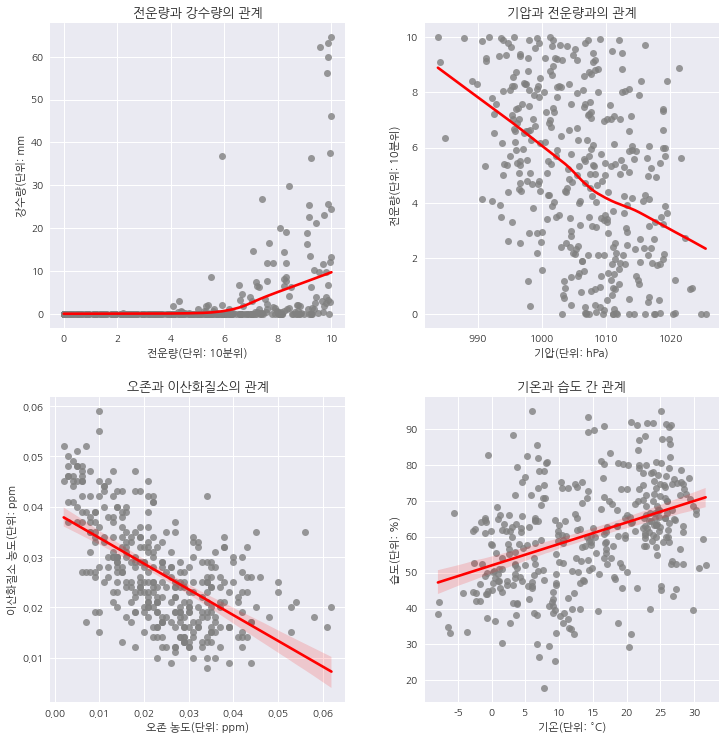

In [ ]:
mpl.rc("font", family = "NanumGothic") # 한글 깨짐 방지

fig, axes = plt.subplots(2,2,figsize=(10, 10))
plt.tight_layout(w_pad = 5, h_pad = 5)
# plt.style.use('seaborn')

ax = sns.regplot(x= 'CLOUD', y = 'RAIN',lowess=True, data = df_merge, ax = axes[0,0], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("전운량과 강수량의 관계", fontsize = 13)
ax.set_xlabel("전운량(단위: 10분위)")
ax.set_ylabel("강수량(단위: mm")

ax = sns.regplot(x= 'ATM_PRESS', y = 'CLOUD', lowess=True, data = df_merge, ax = axes[0,1], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("기압과 전운량과의 관계", fontsize = 13)
ax.set_xlabel("기압(단위: hPa)")
ax.set_ylabel("전운량(단위: 10분위)")

ax = sns.regplot(x= 'O3', y = 'NO2', data = df_merge, ax = axes[1,0], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("오존과 이산화질소의 관계", fontsize = 13)
ax.set_xlabel("오존 농도(단위: ppm)")
ax.set_ylabel("이산화질소 농도(단위: ppm")

ax = sns.regplot(x= 'TEMP', y = 'HUMIDITY', data = df_merge, ax = axes[1,1], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("기온과 습도 간 관계", fontsize = 13)
ax.set_xlabel("기온(단위: °C)")
ax.set_ylabel("습도(단위: %)")

## 결측치 처리

결측치가 있는 데이터의 개수 확인 : CO에서 결측치가 55개 발견된 것을 확인할 수 있음
- 전체 데이터 중 약 15%가 결측치로, 그 비중이 큼   
   : 해당 데이터를 모두 제거하거나, 평균값이나 중간값 등으로 대체하기 어려움
- 일산화탄소는 대기오염물질 중 하나로 미세먼지와 밀접한 관련이 있을 가능성이 큼

In [ ]:
df_merge.isnull().sum()

PM10          1
O3            1
NO2           1
CO           55
TEMP          0
WIND          0
WIND_DIR      0
HUMIDITY      0
ATM_PRESS     0
CLOUD         0
RAIN          0
dtype: int64

In [ ]:
df_merge[df_merge['CO'].isnull()].head()

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,RAIN
25,22.0,0.021,0.027,NaN,25.06,1.72,187,94.9,993.9,9.88,60.0
26,20.0,0.028,0.025,NaN,28.10,1.15,151,78.6,995.6,8.21,0.6
27,16.0,0.018,0.019,NaN,26.31,2.00,179,87.1,998.0,9.88,25.6
28,16.0,0.007,0.017,NaN,27.42,2.66,197,75.0,999.3,8.13,0.5
29,22.0,0.010,0.019,NaN,28.04,3.45,203,75.3,997.2,8.33,1.2


> KNN Imputer   

- 결측치를 제거하거나, 평균값 등으로 대체할 수 없다고 판단했기 때문에 `KNNImputer` 사용
- KNN알고리즘을 통해 결측치를 채움
  - 가까운 이웃의 수를 정하여 그 이웃들의 평균값으로 결측치 계산



In [ ]:
from sklearn.impute import KNNImputer

imputer=KNNImputer(n_neighbors=5)
filled_train=imputer.fit_transform(df_merge)
filled_df=pd.DataFrame(filled_train, columns=df_merge.columns)

In [ ]:
filled_df.isnull().sum()

PM10         0
O3           0
NO2          0
CO           0
TEMP         0
WIND         0
WIND_DIR     0
HUMIDITY     0
ATM_PRESS    0
CLOUD        0
RAIN         0
dtype: int64

## 이상치 처리

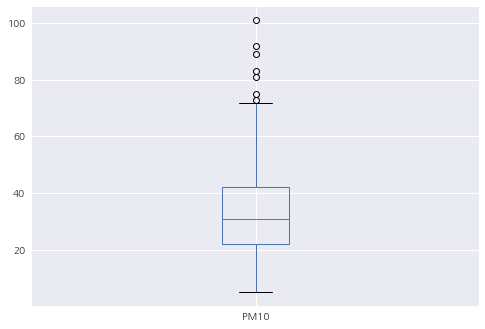

In [ ]:
filled_df.boxplot(['PM10'])

In [ ]:
# boxplot범위를 벗어나는 이상치 제거하기
# IQR 구하기

q1 = filled_df['PM10'].quantile(0.25)
q2 = filled_df['PM10'].quantile(0.5)
q3 = filled_df['PM10'].quantile(0.75)

iqr = q3 - q1
print("PM10 IQR: ", iqr)

PM10 IQR:  20.0


In [ ]:
condition = (filled_df['PM10'] > q3 + 1.5*iqr) | (filled_df['PM10'] < q1 - 1.5*iqr)
filled_df[condition]

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,RAIN
120,83.0,0.021,0.023,0.4,13.05,2.40,286.0,62.1,1004.9,2.21,0.1
123,89.0,0.027,0.037,0.6,15.30,1.80,256.0,60.0,1011.1,2.42,0.0
162,101.0,0.010,0.055,1.0,8.12,1.22,148.0,80.6,1008.7,8.83,1.7
163,73.0,0.021,0.032,0.7,6.95,3.26,230.0,64.5,1006.6,5.58,0.2
227,75.0,0.015,0.032,0.7,6.71,1.68,236.0,85.4,1008.2,8.79,0.0
228,81.0,0.011,0.043,0.9,7.99,1.20,210.0,70.8,1010.2,3.42,0.0
315,92.0,0.034,0.018,0.5,16.65,2.96,276.0,60.8,998.0,7.50,3.4


In [ ]:
index=filled_df[condition].index
filled_df.drop(index,inplace=True)

In [ ]:
# PM10 이상치가 제거된 것을 확인
filled_df[condition]

<ipython-input-264-477ddd581779>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filled_df[condition]


,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,RAIN


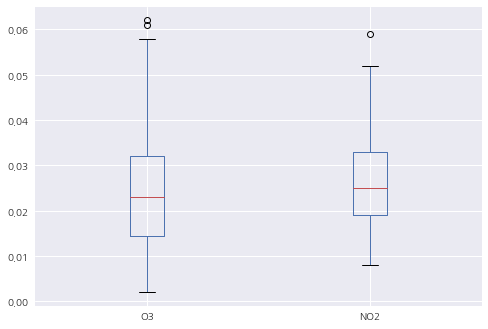

In [ ]:
filled_df.boxplot(['O3', 'NO2'])

In [ ]:
# boxplot범위를 벗어나는 이상치 제거하기
# IQR 구하기

q1 = filled_df['O3'].quantile(0.25)
q2 = filled_df['O3'].quantile(0.5)
q3 = filled_df['O3'].quantile(0.75)
iqr = q3 - q1

condition = (filled_df['O3'] > q3 + 1.5*iqr) | (filled_df['O3'] < q1 - 1.5*iqr)

index=filled_df[condition].index
filled_df.drop(index,inplace=True)

print("O3 이상치 제거 완료")
print("제거된 이상치 개수: ", len(index), "개")

O3 이상치 제거 완료
제거된 이상치 개수:  2 개


In [ ]:
q1 = filled_df['NO2'].quantile(0.25)
q2 = filled_df['NO2'].quantile(0.5)
q3 = filled_df['NO2'].quantile(0.75)

iqr = q3 - q1

condition = (filled_df['NO2'] > q3 + 1.5*iqr) | (filled_df['NO2'] < q1 - 1.5*iqr)

index=filled_df[condition].index
filled_df.drop(index,inplace=True)

print("NO2 이상치 제거 완료")
print("제거된 이상치 개수: ", len(index), "개")

NO2 이상치 제거 완료
제거된 이상치 개수:  1 개


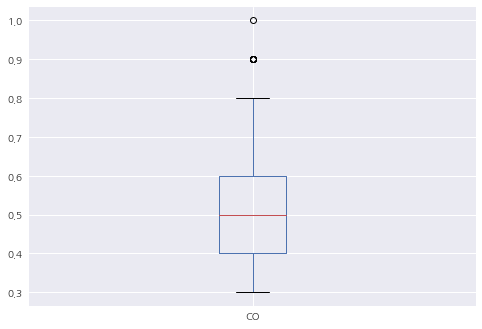

In [ ]:
filled_df.boxplot(['CO'])

In [ ]:
q1 = filled_df['CO'].quantile(0.25)
q2 = filled_df['CO'].quantile(0.5)
q3 = filled_df['CO'].quantile(0.75)

iqr = q3 - q1

condition = (filled_df['CO'] > q3 + 1.5*iqr) | (filled_df['CO'] < q1 - 1.5*iqr)

index=filled_df[condition].index
filled_df.drop(index,inplace=True)

print("CO 이상치 제거 완료")
print("제거된 이상치 개수: ", len(index), "개")

CO 이상치 제거 완료
제거된 이상치 개수:  8 개


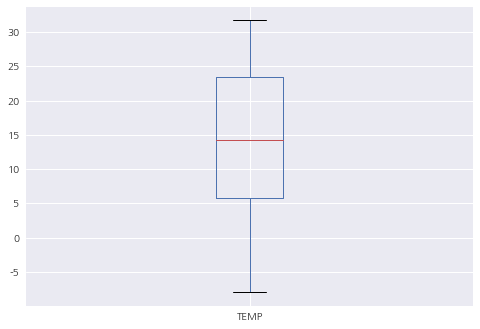

In [ ]:
filled_df.boxplot(['TEMP'])

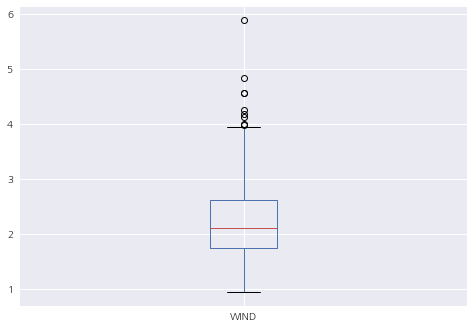

In [ ]:
filled_df.boxplot(['WIND'])

In [ ]:
q1 = filled_df['WIND'].quantile(0.25)
q2 = filled_df['WIND'].quantile(0.5)
q3 = filled_df['WIND'].quantile(0.75)

iqr = q3 - q1

condition = (filled_df['WIND'] > q3 + 1.5*iqr) | (filled_df['WIND'] < q1 - 1.5*iqr)

index=filled_df[condition].index
filled_df.drop(index,inplace=True)

print("WIND 이상치 제거 완료")
print("제거된 이상치 개수: ", len(index), "개")

WIND 이상치 제거 완료
제거된 이상치 개수:  9 개


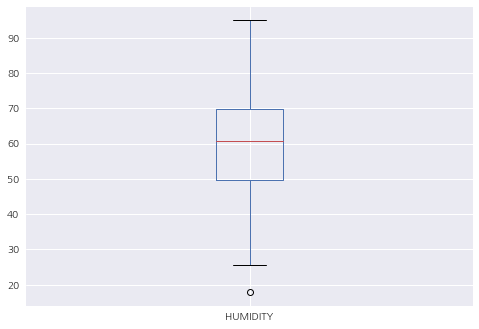

In [ ]:
filled_df.boxplot(['HUMIDITY'])

In [ ]:
q1 = filled_df['HUMIDITY'].quantile(0.25)
q2 = filled_df['HUMIDITY'].quantile(0.5)
q3 = filled_df['HUMIDITY'].quantile(0.75)

iqr = q3 - q1

condition = (filled_df['HUMIDITY'] > q3 + 1.5*iqr) | (filled_df['HUMIDITY'] < q1 - 1.5*iqr)

index=filled_df[condition].index
filled_df.drop(index,inplace=True)

print("HUMIDITY 이상치 제거 완료")
print("제거된 이상치 개수: ", len(index), "개")

HUMIDITY 이상치 제거 완료
제거된 이상치 개수:  1 개


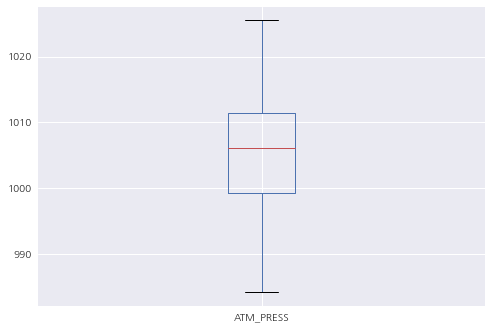

In [ ]:
filled_df.boxplot(['ATM_PRESS'])

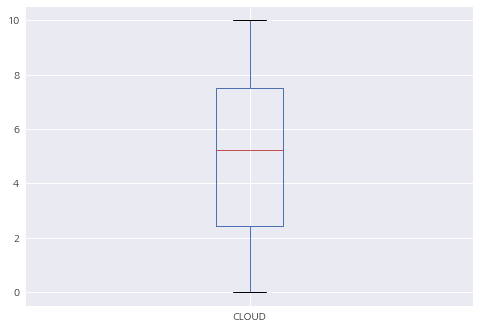

In [ ]:
filled_df.boxplot(['CLOUD'])

### 문제점: RAIN 데이터
- 비가 오지 않은 날이 비가 온 날에 비해 훨씬 데이터가 많아 치우쳐있음
- 결측치의 개수 64개 확인됨
- 이상치를 제거하거나 변경하기엔 비가 왔다는 것이 중요한 데이터라고 판단되므로,   
Feature Enginnering을 통해 범주화하여 분석할 것

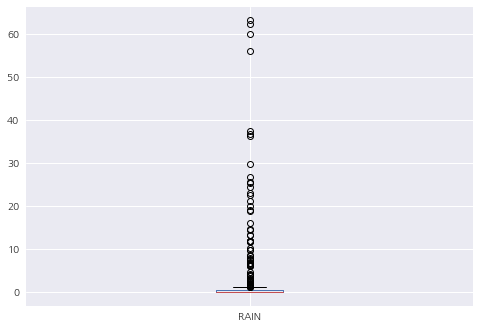

In [ ]:
filled_df.boxplot(['RAIN'])

In [ ]:
q1 = filled_df['RAIN'].quantile(0.25)
q2 = filled_df['RAIN'].quantile(0.5)
q3 = filled_df['RAIN'].quantile(0.75)

iqr = q3 - q1

condition = (filled_df['RAIN'] > q3 + 1.5*iqr) | (filled_df['RAIN'] < q1 - 1.5*iqr)
index=filled_df[condition].index

print("RAIN 이상치 개수: ", len(index), "개")

RAIN 이상치 개수:  68 개


In [ ]:
# # 64개의 이상치 데이터 -> 케이스 분리
# condition = (filled_df['RAIN'] > q3 + 1.5*iqr) | (filled_df['RAIN'] < q1 - 1.5*iqr)
# high_rain_df = filled_df[condition]
# high_rain_df

In [ ]:
# index=filled_df[condition].index
# filled_df.drop(index,inplace=True)

In [ ]:
filled_df

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,RAIN
0,29.0,0.054,0.021,0.5,24.03,2.30,249.0,63.2,995.1,5.70,0.0
1,26.0,0.053,0.020,0.5,24.29,2.26,265.0,63.2,998.6,3.83,0.0
2,30.0,0.042,0.023,0.4,24.18,1.79,280.0,65.3,998.3,6.29,0.0
3,28.0,0.034,0.026,0.4,25.35,2.04,263.0,58.6,996.6,2.54,0.0
4,29.0,0.045,0.035,0.5,27.30,1.45,175.0,45.5,993.5,3.92,0.0
...,...,...,...,...,...,...,...,...,...,...,...
360,13.0,0.023,0.019,0.5,21.54,2.21,163.0,91.2,991.7,10.00,13.3
361,19.0,0.039,0.016,0.4,21.66,3.12,228.0,84.0,996.0,8.73,2.1
362,22.0,0.044,0.017,0.4,23.94,1.93,217.0,69.8,995.8,6.21,0.0
363,27.0,0.044,0.009,0.4,25.03,2.35,283.0,71.3,994.7,2.63,0.0


In [ ]:
# high_rain_df

## Feature Engineering

### WIND_DIR 변수 번주화
> WIND_DIR 풍향을 8방위로 변경해준다.

In [ ]:
def Change_WindDir(x):
        if x >= 0 and x <= 22.5: return '북'
        
        elif x > 22.5 and x <= 67.5: return '북동'  
        elif x > 67.5 and x <= 112.5: return '동'  
        
        elif x > 112.5 and x <= 157.5: return '남동'    
        elif x > 157.5 and x <= 202.5: return '남'  
        
        elif x > 202.5 and x <= 247.5: return '남서'    
        elif x > 247.5 and x <= 292.5: return '서'  
        
        elif x > 292.5 and x <= 337.5: return '북서'  
        elif x > 337.5 and x <= 360: return '북'  

filled_df["WIND_DIR"] = filled_df["WIND_DIR"].apply(Change_WindDir)
# high_rain_df["WIND_DIR"] = high_rain_df["WIND_DIR"].apply(Change_WindDir)

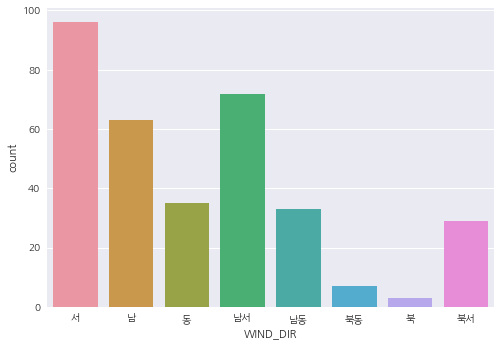

In [ ]:
mpl.rc("font", family = "NanumGothic") # 한글 깨짐 방지

sns.countplot(x = "WIND_DIR", data= filled_df)
plt.show()

### RAIN 변수 범주화

- 강수량 데이터가 0에 지나치게 치우쳐있어, 이상치가 다수 관측됨
- 연속형 데이터를 범주형으로 변환하여 분석하기로 함
- 기상청 기준 강수 표현  
  - 3mm 미만 : 약한 비
  - 3mm이상 ~ 15mm 미만 : 보통 비
  - 15mm이상 ~ 30mm 미만 : 강한 비
  - 30mm이상 : 매우 강한 비

In [ ]:
def Change_Rain(x):
        if x == 0 : return '비 안옴'
        elif x > 0 and x < 3 : return '약함'  
        elif x >= 3 and x < 15 : return '보통'  
        elif x >= 15 and x < 30 : return '강함'  
        elif x >= 30 : return '매우강함'

filled_df['RAIN'] = filled_df["RAIN"].apply(Change_Rain)
filled_df.head()

,PM10,O3,NO2,CO,TEMP,WIND,WIND_DIR,HUMIDITY,ATM_PRESS,CLOUD,RAIN
0,29.0,0.054,0.021,0.5,24.03,2.30,서,63.2,995.1,5.70,비 안옴
1,26.0,0.053,0.020,0.5,24.29,2.26,서,63.2,998.6,3.83,비 안옴
2,30.0,0.042,0.023,0.4,24.18,1.79,서,65.3,998.3,6.29,비 안옴
3,28.0,0.034,0.026,0.4,25.35,2.04,서,58.6,996.6,2.54,비 안옴
4,29.0,0.045,0.035,0.5,27.30,1.45,남,45.5,993.5,3.92,비 안옴


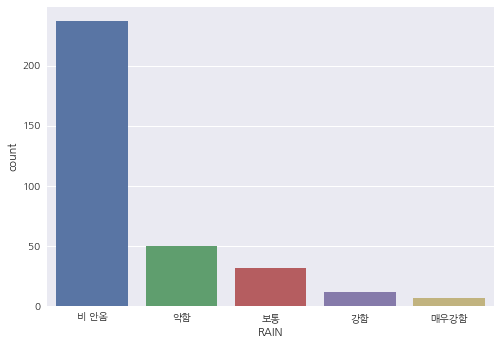

In [ ]:
mpl.rc("font", family = "NanumGothic") # 한글 깨짐 방지

sns.countplot(x = "RAIN", data= filled_df, order = ['비 안옴', '약함', '보통', '강함', '매우강함'])

### Roubust Scaler
- 표준 정규화
- 중간값과 사분위값을 사용하여 이상치의 영향을 최소화

In [ ]:
from sklearn.preprocessing import RobustScaler
# %matplotlib inline

df_num = filled_df.select_dtypes(exclude = "object") # 수치형 데이터만 뽑아내기
df_robust = RobustScaler().fit_transform(df_num)
df_robust = pd.DataFrame(df_scale_robust, columns = df_num.columns)

In [ ]:
df_robust

,PM10,O3,NO2,CO,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
0,-0.055556,1.823529,-0.285714,0.000000,0.524983,0.266667,0.118812,-0.906832,0.092338
1,-0.222222,1.764706,-0.357143,0.000000,0.539457,0.218182,0.118812,-0.616977,-0.275049
2,0.000000,1.117647,-0.142857,-0.540541,0.533333,-0.351515,0.222772,-0.641822,0.208251
3,-0.111111,0.647059,0.071429,-0.540541,0.598469,-0.048485,-0.108911,-0.782609,-0.528487
4,-0.055556,1.294118,0.714286,0.000000,0.707029,-0.763636,-0.757426,-1.039337,-0.257367
...,...,...,...,...,...,...,...,...,...
333,-0.944444,0.000000,-0.428571,0.000000,0.386360,0.157576,1.504950,-1.188406,0.937132
334,-0.611111,0.941176,-0.642857,-0.540541,0.393041,1.260606,1.148515,-0.832298,0.687623
335,-0.444444,1.235294,-0.571429,-0.540541,0.519972,-0.181818,0.445545,-0.848861,0.192534
336,-0.166667,1.235294,-1.142857,-0.540541,0.580654,0.327273,0.519802,-0.939959,-0.510806


In [ ]:
df_robust.describe().round(2)

,PM10,O3,NO2,CO,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD
count,338.00,338.00,338.00,338.00,338.00,338.00,338.00,338.00,338.00
mean,0.10,0.05,0.10,-0.03,-0.02,0.12,-0.03,-0.02,-0.04
std,0.76,0.67,0.68,0.69,0.55,0.76,0.71,0.67,0.59
min,-1.39,-1.24,-1.14,-1.08,-1.26,-1.38,-1.75,-1.81,-1.03
25%,-0.44,-0.47,-0.43,-0.54,-0.51,-0.42,-0.55,-0.56,-0.55
50%,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00
75%,0.56,0.53,0.57,0.46,0.49,0.58,0.45,0.44,0.45
max,2.33,2.06,1.93,1.62,0.95,2.25,1.69,1.61,0.94


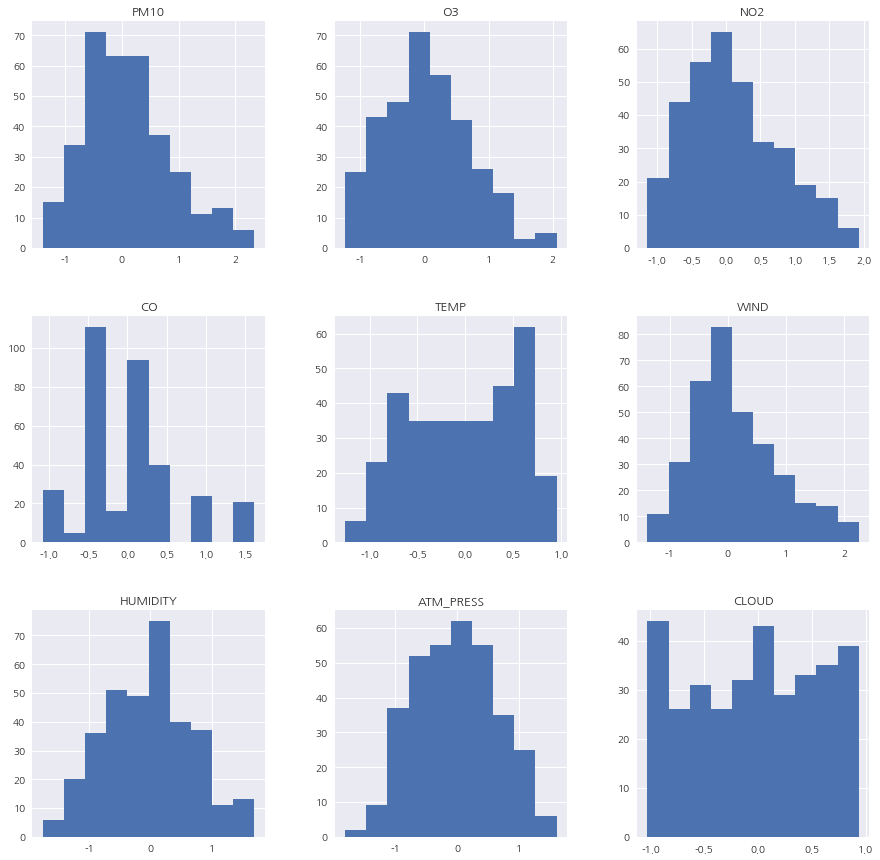

In [ ]:
ax = df_robust.hist(figsize = (15,15))

In [ ]:
df_robust['RAIN'] = filled_df['RAIN']
df_robust['WIND_DIR'] = filled_df['WIND_DIR']
df_robust

,PM10,O3,NO2,CO,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,RAIN,WIND_DIR
0,-0.055556,1.823529,-0.285714,0.000000,0.524983,0.266667,0.118812,-0.906832,0.092338,비 안옴,서
1,-0.222222,1.764706,-0.357143,0.000000,0.539457,0.218182,0.118812,-0.616977,-0.275049,비 안옴,서
2,0.000000,1.117647,-0.142857,-0.540541,0.533333,-0.351515,0.222772,-0.641822,0.208251,비 안옴,서
3,-0.111111,0.647059,0.071429,-0.540541,0.598469,-0.048485,-0.108911,-0.782609,-0.528487,비 안옴,서
4,-0.055556,1.294118,0.714286,0.000000,0.707029,-0.763636,-0.757426,-1.039337,-0.257367,비 안옴,남
...,...,...,...,...,...,...,...,...,...,...,...
333,-0.944444,0.000000,-0.428571,0.000000,0.386360,0.157576,1.504950,-1.188406,0.937132,비 안옴,서
334,-0.611111,0.941176,-0.642857,-0.540541,0.393041,1.260606,1.148515,-0.832298,0.687623,비 안옴,남
335,-0.444444,1.235294,-0.571429,-0.540541,0.519972,-0.181818,0.445545,-0.848861,0.192534,약함,남서
336,-0.166667,1.235294,-1.142857,-0.540541,0.580654,0.327273,0.519802,-0.939959,-0.510806,약함,서


# 목표변수와 설명변수의 관계 확인

## 연속형 변수 - 상관관계 분석

In [ ]:
df_agg = filled_df.groupby(["WIND_DIR", 'RAIN'], as_index = False).agg("mean")
df_pivot = df_agg.pivot("WIND_DIR", "RAIN", "PM10").round(3)
df_pivot

RAIN,강함,매우강함,보통,비 안옴,약함
WIND_DIR,,,,,
남,27.50,21.0,30.000,37.140,31.300
남동,14.00,27.0,32.429,36.000,34.250
남서,17.00,NaN,25.500,36.125,26.941
동,17.75,25.5,27.875,21.800,39.500
북,8.00,NaN,NaN,NaN,11.500
북동,NaN,NaN,NaN,31.333,35.000
북서,22.00,NaN,22.500,29.458,33.000
서,NaN,12.0,30.200,32.889,34.375


Text(699.6985294117648, 0.5, '미세먼지(단위: ㎍/㎥)')

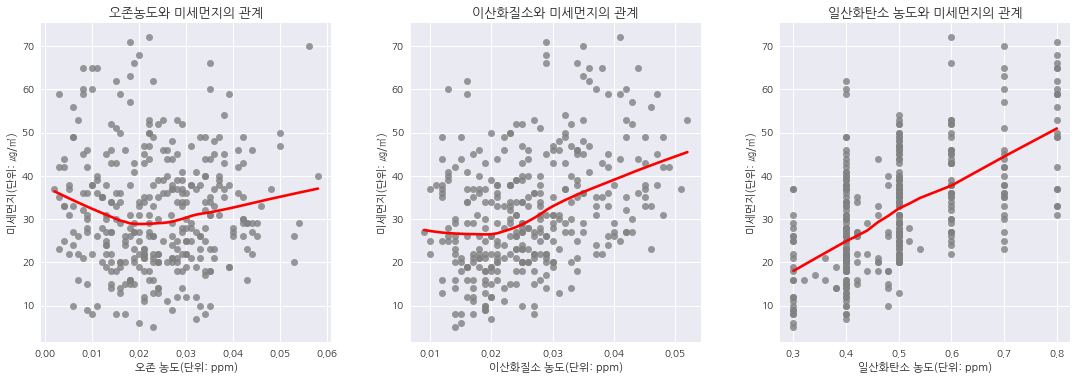

In [ ]:
mpl.rc("font", family = "NanumGothic") # 한글 깨짐 방지

fig, axes = plt.subplots(1,3,figsize=(15, 5))
plt.tight_layout(w_pad = 5, h_pad = 5)
# plt.style.use('seaborn')

ax = sns.regplot(x= 'O3', y = 'PM10',lowess=True, data = filled_df, ax = axes[0], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("오존농도와 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("오존 농도(단위: ppm)")
ax.set_ylabel("미세먼지(단위: ㎍/㎥)")

ax = sns.regplot(x= 'NO2', y = 'PM10',lowess=True, data = filled_df, ax = axes[1], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("이산화질소와 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("이산화질소 농도(단위: ppm)")
ax.set_ylabel("미세먼지(단위: ㎍/㎥)")

ax = sns.regplot(x= 'CO', y = 'PM10',lowess=True, data = filled_df, ax = axes[2], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("일산화탄소 농도와 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("일산화탄소 농도(단위: ppm)")
ax.set_ylabel("미세먼지(단위: ㎍/㎥)")

In [ ]:
o3_r = np.corrcoef(filled_df['PM10'], filled_df['O3'])
no2_r = np.corrcoef(filled_df['PM10'], filled_df['NO2'])
co_r = np.corrcoef(filled_df['PM10'], filled_df['CO'])

print("-*- 대기오염물질과 미세먼지농도의 상관분석 -*-")
print("O3과 PM10의 상관계수", o3_r[0,1].round(3))
print("NO2와 PM10의 상관계수", no2_r[0,1].round(3))
print("CO와 PM10의 상관계수", co_r[0,1].round(3))

-*- 대기오염물질과 미세먼지농도의 상관분석 -*-
O3과 PM10의 상관계수 -0.004
NO2와 PM10의 상관계수 0.381
CO와 PM10의 상관계수 0.603


Text(404.2867647058824, 0.5, '미세먼지(단㎍/㎥)')

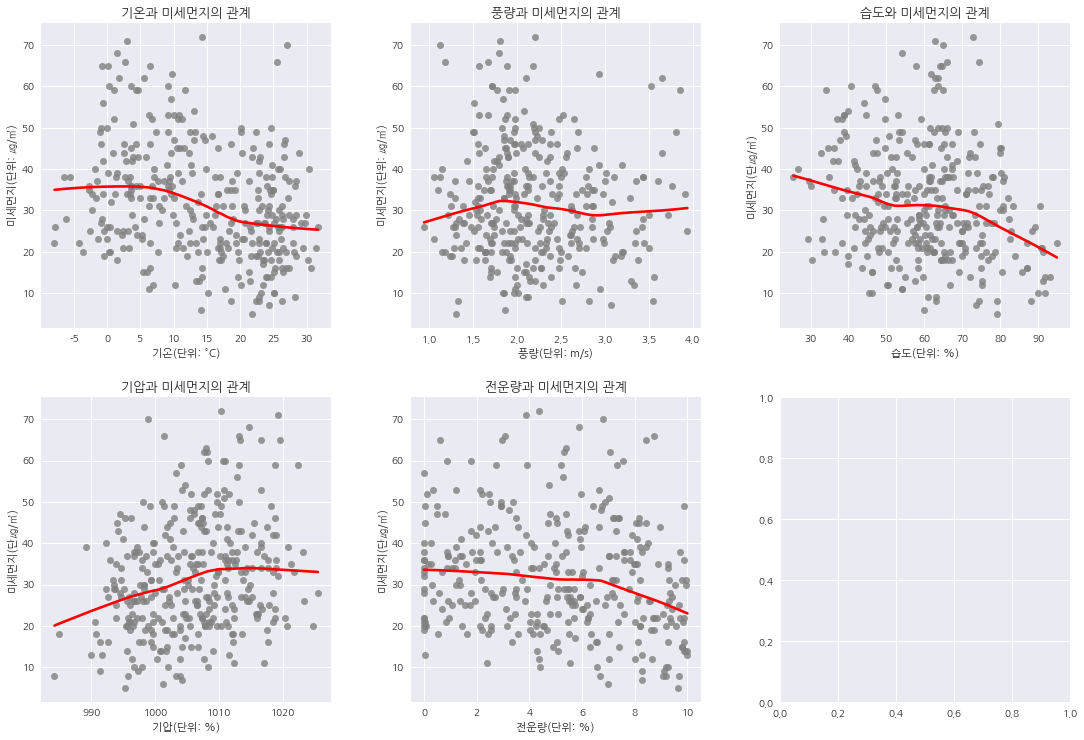

In [ ]:
mpl.rc("font", family = "NanumGothic") # 한글 깨짐 방지

fig, axes = plt.subplots(2,3,figsize=(15, 10))
plt.tight_layout(w_pad = 5, h_pad = 5)
# plt.style.use('seaborn')

ax = sns.regplot(x= 'TEMP', y = 'PM10',lowess=True, data = filled_df, ax = axes[0,0], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("기온과 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("기온(단위: °C)")
ax.set_ylabel("미세먼지(단위: ㎍/㎥)")

ax = sns.regplot(x= 'WIND', y = 'PM10',lowess=True, data = filled_df, ax = axes[0,1], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("풍량과 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("풍량(단위: m/s)")
ax.set_ylabel("미세먼지(단위: ㎍/㎥)")

ax = sns.regplot(x= 'HUMIDITY', y = 'PM10',lowess=True, data = filled_df, ax = axes[0,2], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("습도와 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("습도(단위: %)")
ax.set_ylabel("미세먼지(단㎍/㎥)")

ax = sns.regplot(x= 'ATM_PRESS', y = 'PM10',lowess=True, data = filled_df, ax = axes[1,0], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("기압과 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("기압(단위: %)")
ax.set_ylabel("미세먼지(단㎍/㎥)")

ax = sns.regplot(x= 'CLOUD', y = 'PM10',lowess=True, data = filled_df, ax = axes[1,1], line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
ax.set_title("전운량과 미세먼지의 관계", fontsize = 13)
ax.set_xlabel("전운량(단위: %)")
ax.set_ylabel("미세먼지(단㎍/㎥)")

In [ ]:
temp_r = np.corrcoef(filled_df['PM10'], filled_df['TEMP'])
wind_r = np.corrcoef(filled_df['PM10'], filled_df['WIND'])
humi_r = np.corrcoef(filled_df['PM10'], filled_df['HUMIDITY'])
press_r = np.corrcoef(filled_df['PM10'], filled_df['ATM_PRESS'])
cloud_r = np.corrcoef(filled_df['PM10'], filled_df['CLOUD'])

print("-*- 대기환경요인과 미세먼지농도의 상관분석 -*-")
print("TEMP와 PM10의 상관계수", temp_r[0,1].round(3))
print("WIND와 PM10의 상관계수", wind_r[0,1].round(3))
print("HUMI와 PM10의 상관계수", humi_r[0,1].round(3))
print("ATM_PRESS와 PM10의 상관계수", press_r[0,1].round(3))
print("CLOUD와 PM10의 상관계수", cloud_r[0,1].round(3))

-*- 대기환경요인과 미세먼지농도의 상관분석 -*-
TEMP와 PM10의 상관계수 -0.313
WIND와 PM10의 상관계수 -0.053
HUMI와 PM10의 상관계수 -0.2
ATM_PRESS와 PM10의 상관계수 0.247
CLOUD와 PM10의 상관계수 -0.189


### 범주형 변수 - boxplot

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


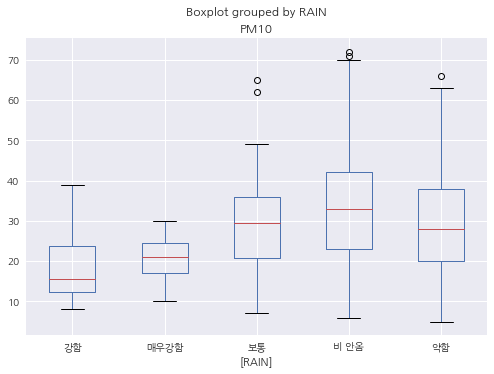

In [ ]:
filled_df.boxplot(column="PM10", by = ["RAIN"])

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


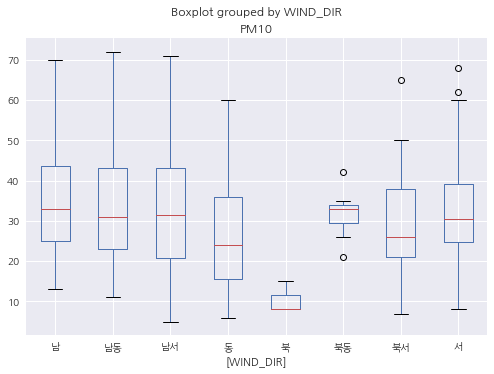

In [ ]:
filled_df.boxplot(column="PM10", by = ["WIND_DIR"])

> ANOVA?   

one-way ANOVA로 집단간의 평균이 유의미한 차이가 있는지 검정하고자 하였으나,  
pvalue < 0.05인 값이 존재하여 정규성을 만족하지 않아 분석할 수 없었다.

--> 집단 간 평균에 유의미한 차이가 있다고 볼 수 없다.

In [ ]:
from scipy.stats import shapiro
print(shapiro(filled_df.PM10[filled_df.RAIN=='매우강함']))
print(shapiro(filled_df.PM10[filled_df.RAIN=='강함']))
print(shapiro(filled_df.PM10[filled_df.RAIN=='보통']))
print(shapiro(filled_df.PM10[filled_df.RAIN=='약함']))
print(shapiro(filled_df.PM10[filled_df.RAIN=='비 안옴']))

ShapiroResult(statistic=0.9674333930015564, pvalue=0.8793720006942749)
ShapiroResult(statistic=0.9167099595069885, pvalue=0.2598226070404053)
ShapiroResult(statistic=0.9430086612701416, pvalue=0.09115556627511978)
ShapiroResult(statistic=0.9544159770011902, pvalue=0.0519438162446022)
ShapiroResult(statistic=0.9739699363708496, pvalue=0.00023926330322865397)


In [ ]:
from scipy.stats import shapiro
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='남']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='남동']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='남서']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='동']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='북']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='북동']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='북서']))
print(shapiro(filled_df.PM10[filled_df.WIND_DIR=='서']))

ShapiroResult(statistic=0.962169349193573, pvalue=0.0501912422478199)
ShapiroResult(statistic=0.9488646984100342, pvalue=0.12325930595397949)
ShapiroResult(statistic=0.9617069363594055, pvalue=0.02759571559727192)
ShapiroResult(statistic=0.9603423476219177, pvalue=0.23412904143333435)
ShapiroResult(statistic=0.7500000596046448, pvalue=-9.106917104872991e-07)
ShapiroResult(statistic=0.9299831986427307, pvalue=0.5507562160491943)
ShapiroResult(statistic=0.9374078512191772, pvalue=0.08576672524213791)
ShapiroResult(statistic=0.9746821522712708, pvalue=0.05977005884051323)


#예측

## 회귀분석


In [ ]:
df_train, df_test = train_test_split(df_robust, test_size= 0.3, random_state= 1234)
print("train data size :{}".format(df_train.shape))
print("tset data size : {}".format(df_test.shape))

train data size :(236, 11)
tset data size : (102, 11)


In [ ]:
# 선형 회귀 분석: formula(y~ X1 + X2 + ...)
reg_model = smf.ols(formula= "PM10 ~ O3 + NO2 + CO + TEMP + WIND + HUMIDITY + ATM_PRESS + CLOUD + C(WIND_DIR) + C(RAIN)", data=df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     12.39
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           1.71e-24
Time:                        14:07:25   Log-Likelihood:                -152.71
No. Observations:                 216   AIC:                             345.4
Df Residuals:                     196   BIC:                             412.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1753      0.19

In [ ]:
# 유의하지 않은 변수 중 p-value가 가장 큰 것을 하나씩 반복적으로 제거
reg_model = smf.ols(formula= "PM10 ~ O3 + CO + WIND + HUMIDITY", data=df_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   PM10   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     56.07
Date:                Sat, 14 Jan 2023   Prob (F-statistic):           5.35e-33
Time:                        14:07:26   Log-Likelihood:                -185.41
No. Observations:                 236   AIC:                             380.8
Df Residuals:                     231   BIC:                             398.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0905      0.036      2.530      0.0

### 결과 및 분석
- 수정 설명계수 : 48.4%
  - 해당 모델은 데이터의 48.4%를 설명한다.
- 유의한 설명변수들의 회귀계수
  - 오존 농도 : 0.4696
  - 일산화탄소 농도 : 0.9286
  - 풍량 : 0.1946
  - 습도 : -0.1974
- Durbin-Watson 정규성 검정
  - 1.5~2.5사이로 잔차는 독립적이라고 판단할 수 있다.
- Cond. No 다중공선성 검정
  - 2.32로 독립변수 간 상관관계가 낮다고 볼 수 있다.

> 미세먼지 농도에 가장 큰 영향을 미치는 독립변수는 일산화탄소라고 볼 수 있다.

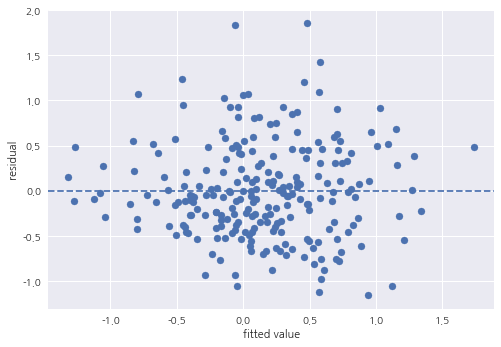

In [ ]:
# 등분산성 검정
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = '--')

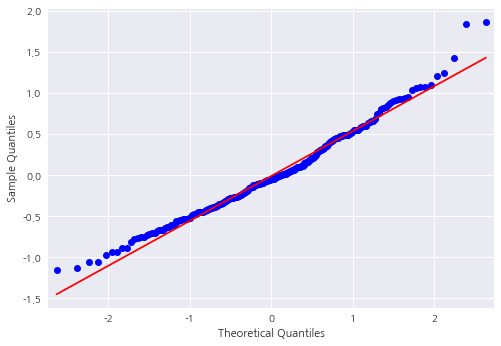

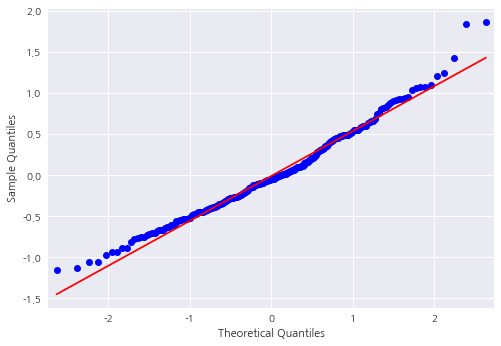

In [ ]:
# 잔차 정규성 검정
qqplot(reg_result.resid, line = 'q')

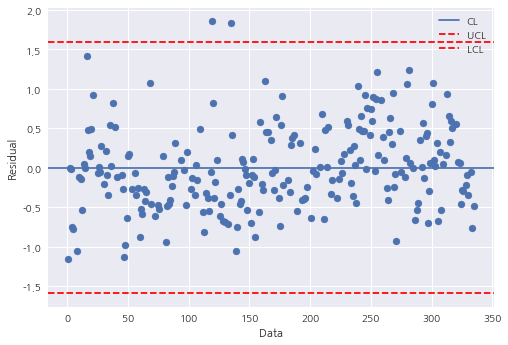

In [ ]:
# 평가용 데이터에 대한 성능 확인
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data"); plt.ylabel("Residual") 
    
# 독립성 검정(관리도)
plt.axhline(y = 0, linestyle="-", label = 'CL')
plt.axhline(y=3*np.std(reg_result.resid), linestyle = "--", color = "red", label = "UCL") # upper control limit. 상부 관리 한계 = 3 * std
plt.axhline(y=-3*np.std(reg_result.resid), linestyle = "dashed", color = "red", label = "LCL") 
plt.legend() ; plt.show()

In [ ]:
# 평가용 데이터에 대한 성능 확인
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정 계수:", r2_score(df_train['PM10'], train_pred))
print("test data의 결정 계수:", r2_score(df_test['PM10'], test_pred))

train data의 결정 계수: 0.492620409902349
test data의 결정 계수: 0.541326196322087


## XGBoost

> Gradient Boosting 기법을 병렬 학습이 지원되도록 구현한 라이브러리

- boosting: 여러 decision tree를 조합해서 사용하는 앙상블 기법. 복잡하지 않은 모델에서 시작하여 이전 모델에 대한 학습을 통해 성능 개선.  
- 기존 GBM의 경우 과적합 규제 기능이 없으나 XGB는 자체 과적합 규제 기능을 가진다.


In [ ]:
df_dummy= pd.get_dummies(df_robust)
df_dummy.head()

,PM10,O3,NO2,CO,TEMP,WIND,HUMIDITY,ATM_PRESS,CLOUD,RAIN_강함,...,RAIN_비 안옴,RAIN_약함,WIND_DIR_남,WIND_DIR_남동,WIND_DIR_남서,WIND_DIR_동,WIND_DIR_북,WIND_DIR_북동,WIND_DIR_북서,WIND_DIR_서
0,-0.055556,1.823529,-0.285714,0.000000,0.524983,0.266667,0.118812,-0.906832,0.092338,0,...,1,0,0,0,0,0,0,0,0,1
1,-0.222222,1.764706,-0.357143,0.000000,0.539457,0.218182,0.118812,-0.616977,-0.275049,0,...,1,0,0,0,0,0,0,0,0,1
2,0.000000,1.117647,-0.142857,-0.540541,0.533333,-0.351515,0.222772,-0.641822,0.208251,0,...,1,0,0,0,0,0,0,0,0,1
3,-0.111111,0.647059,0.071429,-0.540541,0.598469,-0.048485,-0.108911,-0.782609,-0.528487,0,...,1,0,0,0,0,0,0,0,0,1
4,-0.055556,1.294118,0.714286,0.000000,0.707029,-0.763636,-0.757426,-1.039337,-0.257367,0,...,1,0,1,0,0,0,0,0,0,0


In [ ]:
# 목표변수, 설명변수 데이터 지정
df_y = df_dummy["PM10"]
df_x = df_dummy.drop("PM10", axis = 1)

In [ ]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (236, 21)
train data Y size: (236,)
test data X size: (102, 21)
test data Y size: (102,)


### 모델 생성

In [ ]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(df_train_x, df_train_y)

# Train data 설명력
print("Score on training set: {:.3f}".format(xg_reg.score(df_train_x, df_train_y)))

# test data 설명력
print("Score on test set: {:.3f}".format(xg_reg.score(df_test_x, df_test_y)))

Score on training set: 0.470
Score on test set: 0.146


- 모델 설명력은 train 47.0%, test 14.6%로 설명력이 낮음

### 모델 파라미터 조정: Grid Search

In [ ]:
xgb= XGBRegressor()

xgb_grid=GridSearchCV(xg_reg, {
    'n_estimators' : [100,200,300,400,500],
    'learning_rate' : [0.01,0.05,0.1,0.15],
    'max_depth' : [3,5,7,10,15],
    'gamma' : [0,1,2,3],
    'colsample_bytree' : [0.8,0.9]},
    verbose = 1)

xgb_grid.fit(df_train_x, df_train_y)
print("best param : ",xgb_grid.best_params_)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
best param :  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300}


### 결과 확인

In [ ]:
#dataframe으로 랭킹순보기
result_df = pd.DataFrame(xgb_grid.cv_results_)
result_df.sort_values(by=['rank_test_score'],inplace=True)

#plot
result_df[['params','mean_test_score','rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
172,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.423262,1
170,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.422947,2
171,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.422947,3
173,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.422292,4
174,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.422158,5
167,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.418506,6
561,"{'colsample_bytree': 0.9, 'gamma': 1, 'learnin...",0.418277,7
560,"{'colsample_bytree': 0.9, 'gamma': 1, 'learnin...",0.417802,8
562,"{'colsample_bytree': 0.9, 'gamma': 1, 'learnin...",0.417636,9
166,"{'colsample_bytree': 0.8, 'gamma': 1, 'learnin...",0.417520,10


In [ ]:
xgb_grid_best = XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.8, gamma = 1, learning_rate = 0.1, max_depth = 15, n_estimators = 300)
xgb_grid_best.fit(df_train_x, df_train_y)

# Train data 설명력
print("Score on training set: {:.3f}".format(xgb_grid_best.score(df_train_x, df_train_y)))

# test data 설명력
print("Score on test set: {:.3f}".format(xgb_grid_best.score(df_test_x, df_test_y)))

Score on training set: 0.822
Score on test set: 0.485


- 모델 설명력은 train 82.2%, test 48.5%로 설명력이 높아진 것을 확인할 수 있음